In [ ]:
import os
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
!pip install gymnasium[mujoco]

In [ ]:
def evaluate_keyframes(keyframes, render=False, num_runs=3):
    env = gym.make("Walker2d-v5", render_mode=None)
    total_rewards = []

    for _ in range(num_runs):
        observation, info = env.reset(seed=42)
        keyframe_index = 0
        remaining_steps = int(keyframes[keyframe_index][-1])
        episode_reward = 0

        while True:
            action = keyframes[keyframe_index][:-1]
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            if render:
                env.render()

            remaining_steps -= 1
            if remaining_steps == 0:
                keyframe_index = (keyframe_index + 1) % len(keyframes)
                remaining_steps = keyframes[keyframe_index][-1]

            if terminated or truncated:
                break

        total_rewards.append(episode_reward)

    env.close()
    return np.mean(total_rewards)


In [ ]:
def generate_random_keyframes(K):
    return [np.append(np.random.uniform(-1, 1, 6), np.random.randint(5, 50)) for _ in range(K)]

def initialize_population(pop_size, K):
    return [generate_random_keyframes(K) for _ in range(pop_size)]


In [ ]:
def tournament_selection(population, fitness_scores, k):
    selected = random.sample(list(zip(population, fitness_scores)), k)
    return max(selected, key=lambda x: x[1])[0]

def roulette_wheel_selection(population, fitness_scores):
    fitness_scores = np.array(fitness_scores) - np.min(fitness_scores) + 1e-6
    selection_probs = fitness_scores / np.sum(fitness_scores)
    return population[np.random.choice(len(population), p=selection_probs)]

def rank_selection(population, fitness_scores):
    sorted_pop = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0])]
    rank_probs = np.linspace(1, len(sorted_pop), len(sorted_pop))
    rank_probs /= np.sum(rank_probs)
    return sorted_pop[np.random.choice(len(sorted_pop), p=rank_probs)]


In [ ]:
def crossover(parent1, parent2):
    child = []
    for kf1, kf2 in zip(parent1, parent2):
        mask = np.random.rand(len(kf1)) < 0.5
        child_kf = np.where(mask, kf1, kf2)
        child.append(child_kf)
    return child

def mutate(keyframes, mutation_rate):
    for keyframe in keyframes:
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.randint(6)
            keyframe[mutation_index] += np.random.normal(0, 0.1)
    return keyframes


In [ ]:
def evolutionary_optimization(pop_size, generations, mutation_rate, crossover_rate, keyframe_count, tournament_size, step_limit, elite_count, stagnation_limit, selection_strategy):
    population = initialize_population(pop_size, keyframe_count)
    best_fitness_over_generations = []

    for generation in range(generations):
        fitness_scores = [evaluate_keyframes(ind) for ind in population]

        best_fitness = max(fitness_scores)
        best_fitness_over_generations.append(best_fitness)
        print(f"Generation {generation}: Best Reward = {best_fitness}")

        new_population = []
        for _ in range(pop_size // 2):
            if selection_strategy == "tournament":
                parent1 = tournament_selection(population, fitness_scores, tournament_size)
                parent2 = tournament_selection(population, fitness_scores, tournament_size)
            elif selection_strategy == "roulette":
                parent1 = roulette_wheel_selection(population, fitness_scores)
                parent2 = roulette_wheel_selection(population, fitness_scores)
            elif selection_strategy == "rank":
                parent1 = rank_selection(population, fitness_scores)
                parent2 = rank_selection(population, fitness_scores)
            else:
                raise ValueError("Invalid selection strategy")

            if np.random.rand() < crossover_rate:
                child1 = mutate(crossover(parent1, parent2), mutation_rate)
                child2 = mutate(crossover(parent2, parent1), mutation_rate)
            else:
                child1, child2 = parent1, parent2

            new_population.extend([child1, child2])

        population = new_population

    best_solution = population[np.argmax(fitness_scores)]
    return best_solution, best_fitness_over_generations


Generation 0: Best Reward = 44.473526708186576
Generation 1: Best Reward = 45.94704027548496
Generation 2: Best Reward = 59.08636769061471
Generation 3: Best Reward = 105.77355966077431
Generation 4: Best Reward = 105.77355966077431
Generation 5: Best Reward = 291.7002471032801
Generation 6: Best Reward = 116.46240045962107
Generation 7: Best Reward = 174.14062901893757
Generation 8: Best Reward = 216.70248094135573
Generation 9: Best Reward = 140.7583421185248
Generation 10: Best Reward = 198.2244707320766
Generation 11: Best Reward = 172.47894657427807
Generation 12: Best Reward = 191.70514457606342
Generation 13: Best Reward = 216.87168447225517
Generation 14: Best Reward = 225.39311019464117
Generation 15: Best Reward = 255.12393049583423
Generation 16: Best Reward = 251.81891763876354
Generation 17: Best Reward = 240.4910869362205
Generation 18: Best Reward = 372.4205799839055
Generation 19: Best Reward = 372.4205799839055
Generation 20: Best Reward = 337.2875911001927
Generation 

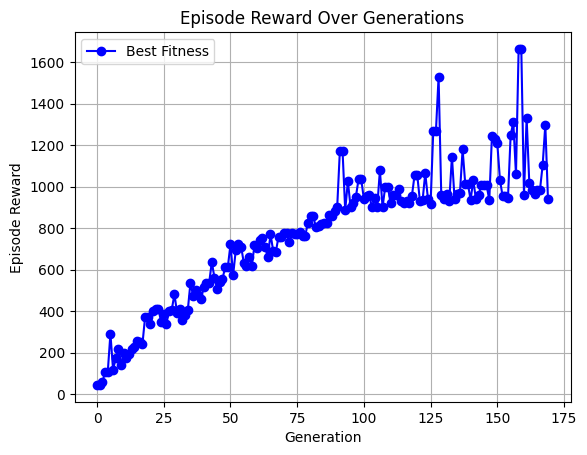

In [ ]:
def main():
    best_keyframes, fitness_over_generations = evolutionary_optimization(
        pop_size=150,
        generations=170,
        mutation_rate=0.125,
        crossover_rate=0.9,
        keyframe_count=6,
        tournament_size=12,
        step_limit=6000,
        elite_count=50,
        stagnation_limit=50,
        selection_strategy="rank"
    )

    print("\nBest keyframes obtained:", best_keyframes)

    num_tests = 5
    test_rewards = [evaluate_keyframes(best_keyframes) for _ in range(num_tests)]
    avg_reward = np.mean(test_rewards)
    print(f"Final Reward of Best Solution (Average over {num_tests} runs): {avg_reward}")

    with open("best_keyframes.txt", "w") as f:
        f.write(f"{len(best_keyframes)}\n")
        for keyframe in best_keyframes:
            f.write(", ".join(map(str, keyframe)) + "\n")

    plt.plot(fitness_over_generations, label="Best Fitness", color="blue", linestyle="-", marker="o")
    plt.xlabel("Generation")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

main()
